In [1]:
from pycigar.envs import Env
import yaml

import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

class FooEnv(Env):
    @property
    def observation_space(self):
        return Box(low=-float('inf'), high=float('inf'),
                   shape=(5,), dtype=np.float64)

    @property
    def action_space(self):
        return Box(low=0.5, high=1.5, shape=(5,), dtype=np.float64)

    def step(self, rl_actions=None, randomize_rl_update=None):
        """See parent class.
        """

        for _ in range(self.sim_params['env_config']["sims_per_step"]):
            self.env_time += 1
            
            # perform action update for PV inverter device
            if len(self.k.device.get_norl_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_norl_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_norl_device_ids(), control_setting)


            self.additional_command()

            if self.k.time <= self.k.t:
                self.k.update(reset=False)

                # check whether the simulator sucessfully solved the powerflow
                converged = self.k.simulation.check_converged()
                if not converged:
                    break

            if self.k.time >= self.k.t:
                break

        # the episode will be finished if it is not converged.
        done = not converged or (self.k.time == self.k.t)
        obs = self.get_state()
        infos = {}
        reward = self.compute_reward(rl_actions)

        return obs, reward, done, infos

    def get_state(self):
        return [0, 0, 0, 0, 0]

    def compute_reward(self, rl_actions, **kwargs):
        return 0

stream = open("./data/pycigar_config.yaml", "r")
sim_params = yaml.safe_load(stream)

print('Simulation Complete')

Simulation Complete


In [2]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.battery_storage_controller import BatteryStorageController
from pycigar.devices.battery_storage_device import BatteryStorageDevice
from pycigar.devices.battery_storage_device_advanced import BatteryStorageDeviceAdvanced

from pycigar.controllers.battery_peak_shaving_controller import BatteryPeakShavingController

# register_devcon('battery_storage_controller', BatteryStorageController)
register_devcon('battery_peak_shaving_controller', BatteryPeakShavingController)
register_devcon('battery_storage_device_advanced', BatteryStorageDeviceAdvanced)


'battery_storage_device_advanced'

In [3]:
sim_params

{'is_disable_log': False,
 'is_disable_y': False,
 'vectorized_mode': False,
 'env_config': {'clip_actions': 'True,', 'sims_per_step': 20},
 'simulation_config': {'network_model_directory': '/home/michael/Desktop/git/ceds-cigar/pycigar/zzz/data/ieee3.dss',
  'custom_configs': {'solution_mode': 1,
   'solution_number': 1,
   'solution_step_size': 1,
   'solution_control_mode': -1,
   'solution_max_control_iterations': 1000000,
   'solution_max_iterations': 30000,
   'power_factor': 0.9}},
 'scenario_config': {'network_data_directory': '/home/michael/Desktop/git/ceds-cigar/pycigar/zzz/data/load_solar_data.csv',
  'multi_config': False,
  'start_end_time': [3600, 3720],
  'custom_configs': {'load_scaling_factor': 1.5,
   'solar_scaling_factor': 0,
   'slack_bus_voltage': 1.04,
   'load_generation_noise': False,
   'power_factor': 0.9},
  'nodes': [{'name': 's701a',
    'devices': [{'name': 'pv_1',
      'device': 'pv_device',
      'custom_device_configs': {'default_control_setting': [0.9

In [4]:
env = FooEnv(sim_params)
env.reset()
done = False
while not done:
    _, _, done, _ = env.step()
    # if env.k.time % 60 == 0:
    #     print('Time: ' + str(env.k.time))
    
print('Simulation Complete')

Time: 51
Measured active power [kW]: 1037.0800382902344
Measured reactive power [kVAr]: 615.9848254887661
Measured apparent power [kVA]: 1206.222330688874
Active Power Control k-1 [kW]: 0
Load active power [kW]: 1037.0800382902344
Load reactive power [kVAr]: 615.9848254887661
Load apparent power [kVA]: 1206.222330688874
Discharge
Discharge power non rectified [kW]: 137.08003829023437
Discharge power [kW]: 137.08003829023437

Time: 52
Measured active power [kW]: 809.6988454831876
Measured reactive power [kVAr]: 574.0312149415894
Measured apparent power [kVA]: 992.5341586585945
Active Power Control k-1 [kW]: 137.08003829023437
Load active power [kW]: 946.778883773422
Load reactive power [kVAr]: 574.0312149415894
Load apparent power [kVA]: 1107.2046290034034
Discharge
Discharge power non rectified [kW]: 46.77888377342197
Discharge power [kW]: 46.77888377342197

Time: 53
Measured active power [kW]: 897.1357707493192
Measured reactive power [kVAr]: 588.9647392466703
Measured apparent power 

In [5]:
from pycigar.utils.logging import logger

Logger = logger()

Logger.log_dict.keys()

dict_keys(['pv_1', 'bsd_1', 's701a', 's702a', 's703a', 'network'])

In [6]:
env.k.device.devices

{'pv_1': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f478eb3a810>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f478eb43910>,
  'node_id': 's701a'},
 'bsd_1': {'device': <pycigar.devices.battery_storage_device_advanced.BatteryStorageDeviceAdvanced at 0x7f478eb43610>,
  'controller': <pycigar.controllers.battery_peak_shaving_controller.BatteryPeakShavingController at 0x7f478eb43750>,
  'node_id': 's701a'}}

In [7]:
# Logger.log_dict['s701a'].keys()
# Logger.log_dict['s701a']['q']
# Logger.log_dict['bsd_1'].keys()
# Logger.log_dict['bsd_1']['SOC']
# Logger.log_dict['pv_1'].keys()
# Logger.log_dict['pv_1']['q_out']

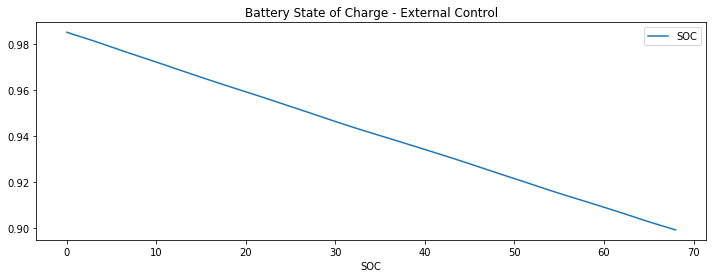

In [8]:
Logger.log_dict['bsd_1'].keys()
# Logger.log_dict['bsd_1']['SOC']

fig1 = plt.figure(figsize = [12, 4])
plt.plot(Logger.log_dict['bsd_1']['SOC'],label="SOC")
plt.title('Battery State of Charge - External Control')
plt.xlabel('Time [s]')
plt.xlabel('SOC')
plt.legend()

fig1.savefig('/home/michael/Desktop/temp/SOC.png')

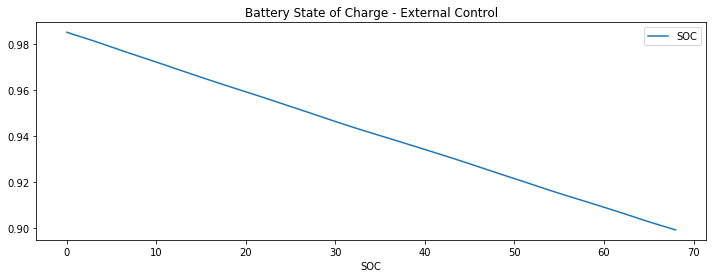

In [9]:
fig1